In [1]:
import cv2
import torch
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from skimage import io
from PlateDetect import Detect
from PerspectivePlate import Perspective

YOLOv5 🚀 v6.0-16-g6d9b99f torch 1.9.1+cu102 CPU

Fusing layers... 
Model Summary: 316 layers, 21472671 parameters, 0 gradients
Adding AutoShape... 


In [2]:
def ShowImage(images):
    fig= plt.figure(figsize=(10, 7))
    rows= 2; columns= 2
    for i,img in enumerate(images):
        fig.add_subplot(rows, columns, i+1)
        plt.imshow(img, cmap="gray")

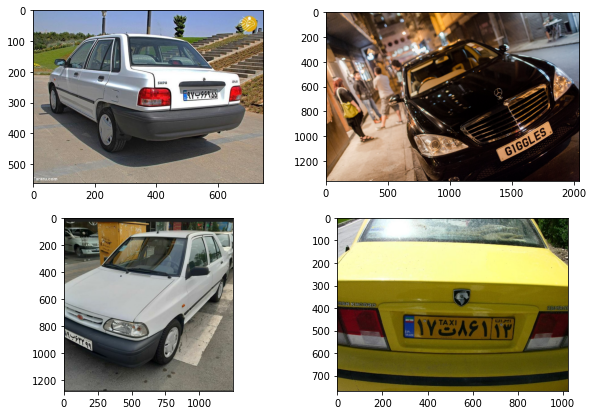

In [3]:
folder= 'yolov5/image/'
names= ['car3.jpg', 'car13.jpg', 'car4.jpg', '215.jpg']

images= []
for name in names:
    image = cv2.imread(folder+name)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    images.append(image)
    
ShowImage(images)

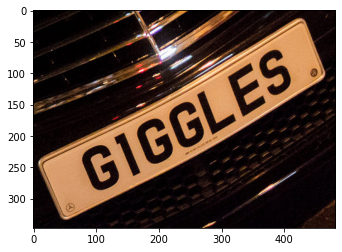

In [4]:
plate= images[1].copy()
pts= Detect(plate)
x,y,w,h, _, _= pts[0]
xplate= plate[y:h, x:w]
plt.imshow(xplate, cmap="gray")

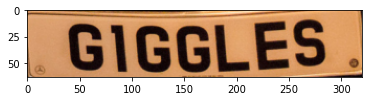

In [5]:
plate_pers= Perspective(xplate)
plt.imshow(plate_pers, cmap="gray")

In [8]:
def secondCrop(img):
    gray=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret,thresh = cv2.threshold(gray,127,255,0)
    contours,_ = cv2.findContours(thresh,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)
    areas = [cv2.contourArea(c) for c in contours]
    if(len(areas)!=4):
        max_index = np.argmax(areas)
        cnt=contours[max_index]
        x,y,w,h = cv2.boundingRect(cnt)
        bounds = cv2.boundingRect(cnt)
        secondCrop=cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)
#         secondCrop = img[y:y+h,x:x+w]
    else:
        secondCrop = img
    return secondCrop

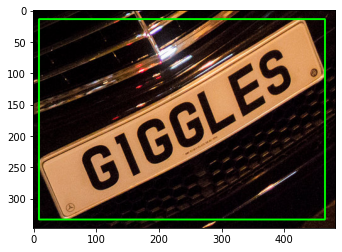

In [9]:
secondCrop= secondCrop(xplate.copy())
plt.imshow(secondCrop, cmap="gray");

# Segmenting

In [10]:
def refine_cut(cuts, no_recursion=False):
    """" refine created cuts (multiple cuts into one) """
    prev_c = 0
    c_bank = []
    temp_c = []
    for c in cuts:
        temp_c.append(c)
        if (c - prev_c) > 10:
            c_bank.append(temp_c)
            temp_c = []
        prev_c = c
    cuts0 = [0, ]
    if no_recursion:
        for i in c_bank:
            cuts0.append(int(np.max(np.array(i))))
    else:
        for i in c_bank:
            cuts0.append(int(np.mean(np.array(i))))
    if no_recursion:
        return cuts0
    else:
        return refine_cut(cuts0, no_recursion=True)

In [11]:
def cut_image(img0, cut_points):
    """ cut image with the given cut points"""
    img = np.copy(img0)
    imgs = []
    for i in range(len(cut_points)):
        imgs.append(img[:, cut_points[i - 1]: cut_points[i], :])
        if i == len(cut_points) - 1:
            imgs.append(img[:, cut_points[i]:, :])
    return imgs

In [12]:
def Segmenting(img_and_masks):
    img = img_and_masks
    blur = cv2.GaussianBlur(cv2.cvtColor(img, cv2.COLOR_RGB2GRAY), (5, 5), 0)
    ret2, th2 = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    th2 = th2.astype(np.uint8) // 255
    horizontal_hist = np.sum(th2, axis=0)
    seg_thresh = np.max(horizontal_hist) * 0.87
    cut_points2 = np.where(horizontal_hist > seg_thresh)[0]

    cut_points2 = refine_cut(cut_points2)
    seged_imgs = cut_image(img, cut_points2)

    return seged_imgs

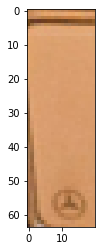

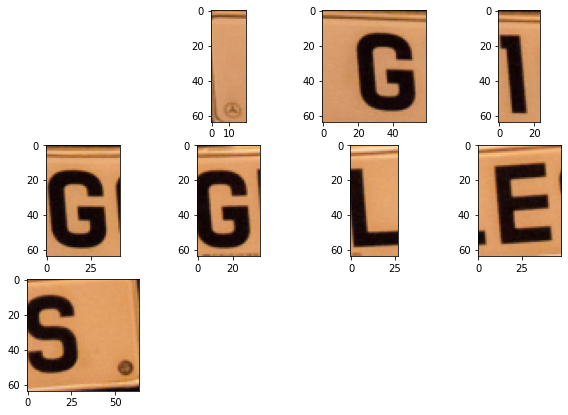

In [17]:
PlateSeg= Segmenting(plate_pers)

plt.imshow(PlateSeg[1])
fig= plt.figure(figsize=(10, 7))
rows= 3; columns= 4
for i in range(len(PlateSeg)):
    if PlateSeg[i].size:
        fig.add_subplot(rows, columns, i+1)
        plt.imshow(PlateSeg[i], cmap="gray")